In [3]:
import numpy as np
import matplotlib.pyplot as plt

from math import ceil, floor
from scipy.optimize import minimize
from tqdm import tqdm

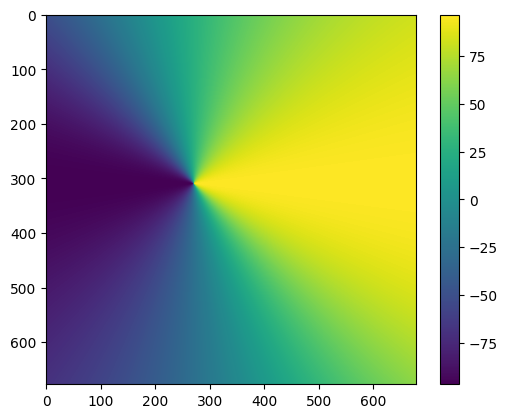

In [44]:
#checking the vaildity of the source plane map

import matplotlib.pyplot as plt

# import the LensModel class #
from lenstronomy.LensModel.lens_model import LensModel

# specify the choice of lens models #
lens_model_list = ['SIE']

# setup lens model class with the list of lens models #
lensModel = LensModel(lens_model_list=lens_model_list)

# define parameter values of lens models #
kwargs_sie = {'theta_E': 100, 'e1':0, 'e2':0.4, 'center_x': 270, 'center_y': 310}
kwargs_lens = [kwargs_sie]

# image plane coordinate #
size = 678
x_grid, y_grid = np.meshgrid(np.linspace(0, size-1, size), np.linspace(0, size-1, size))
# Flatten the grid for calculations
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()

# Calculate convergence (kappa)
kappa = lensModel.kappa(x_flat, y_flat, kwargs_lens)

# Reshape back to 2D grid
#kappa_2d = kappa.reshape(x_grid.shape)

# ray-tracing to the source plane

alpha_x, alpha_y = lensModel.alpha(x_flat, y_flat, kwargs_lens)
# make beta_x and beta_y 2d

alpha_x_2d = alpha_x.reshape(x_grid.shape) #(y,x)
alpha_y_2d = alpha_y.reshape(x_grid.shape) #(y,x)


plt.imshow(alpha_x_2d)
plt.colorbar()


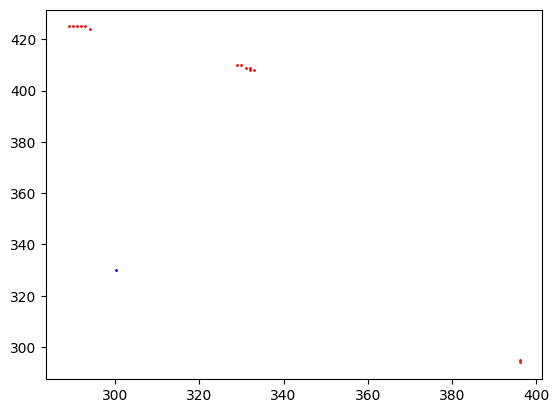

In [45]:
coord = (300.3,330.2)
def find_rough_def_pix(coord):  
    coord_x_r, coord_y_r = coord[0] % 1, coord[1] % 1
    y_round, x_round = round(coord[1]), round(coord[0])

    # Pre-calculate possible matching rounded values for efficiency
    y_possible_rounds = {y_round, y_round - 1} if coord_y_r == 0.5 else {y_round}
    x_possible_rounds = {x_round, x_round - 1} if coord_x_r == 0.5 else {x_round}

    coordinates = []
    n = 0

    # Iterate over a pre-defined range, assuming alpha_y_2d and alpha_x_2d are indexed appropriately
    for i in range(size):
        for j in range(size):
            ycoord, xcoord = i - alpha_y_2d[i, j], j - alpha_x_2d[i, j]
            if round(ycoord) in y_possible_rounds and round(xcoord) in x_possible_rounds:
                coordinates.append((j, i))  # (x, y)
                n += 1

    plt.scatter([i[0] for i in coordinates], [i[1] for i in coordinates], c='r', s=1)
    plt.scatter(coord[0], coord[1], c='b', s=1)
    
    return coordinates
coordinates = find_rough_def_pix(coord)


Number of pixels: [2, 6, 6]


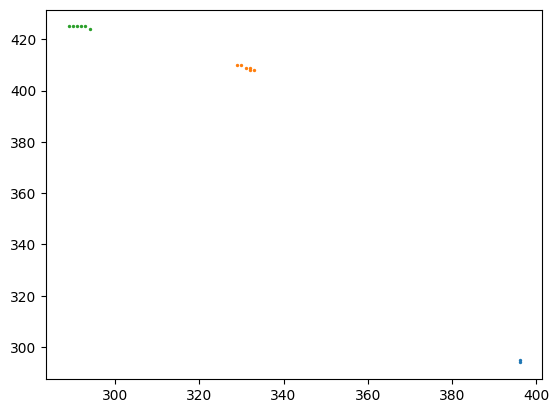

In [46]:
coordinates = np.array(coordinates)

#DBSCAN clustering
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=3, min_samples=1).fit(coordinates)
labels = dbscan.labels_
images = {}
for label in set(labels):
    if label != -1:  # Ignore noise points
        images[f"Image_{label}"] = coordinates[labels == label]
images = list(images.values())

for i in range(0, len(images)):
    plt.scatter(images[i][:,0], images[i][:,1], s=2)
print(f'Number of pixels: {[np.sum(len(images[i])) for i in range(0, len(images))]}')


In [58]:
# interpolate the deflected angle given the image pos
def def_angle_test_interpolate(x,y, alpha_x= alpha_x_2d, alpha_y = alpha_y_2d):  #(x,y) is img_guess
    dx = x - floor(x)
    dy = y - floor(y)
    top_left = np.array([alpha_x[ceil(y), floor(x)], alpha_y[ceil(y), floor(x)]]) #to match (y,x) of alpha grid
    top_right = np.array([alpha_x[ceil(y), ceil(x)], alpha_y[ceil(y), ceil(x)]])
    bottom_left = np.array([alpha_x[floor(y), floor(x)], alpha_y[floor(y), floor(x)]])
    bottom_right = np.array([alpha_x[floor(y), ceil(x)], alpha_y[floor(y), ceil(x)]])
    top = top_left * (1 - dx) + top_right * dx
    bottom = bottom_left * (1 - dx) + bottom_right * dx
    alpha = top * dy + bottom *(1 - dy)
    src_guess = np.array([x-alpha[0], y-alpha[1]])
    return src_guess, alpha
                                             
def diff_interpolate (img_guess):
    src_guess = def_angle_test_interpolate(img_guess[0],img_guess[1])[0]
    return np.sqrt((src_guess[0]-coord[0])**2 + (src_guess[1]-coord[1])**2)

print(def_angle_test_interpolate(292.20972086, 424.15360026)[1])

[-7.96362043 94.72902293]


396 396 294 295 [396.20823956 295.24096109] 1.094149459047022e-08
329 333 408 410 [330.85678807 409.52795438] 1.2985770701138056e-09
289 294 424 425 [292.20972086 424.95360026] 2.7262604468482613e-09


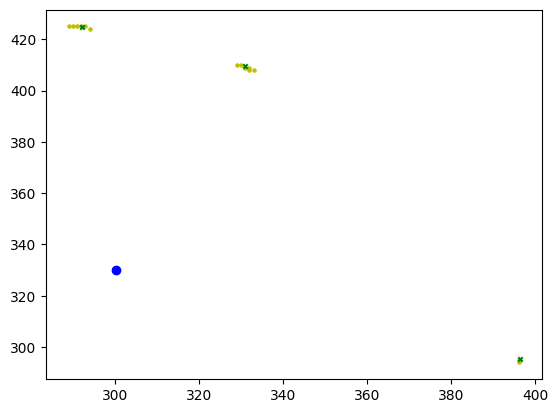

In [48]:
# minimum distance between the source position and the guess source positions deflected by mutiple images
# expect partition of the images and search for 1 sol for 1 image
plt.scatter(coord[0], coord[1], c='b')
plt.scatter([i[0] for i in coordinates], [i[1] for i in coordinates], c='y', s=5)
# find maximum x and y coordinates of the image[i]
for i in range(len(images)):
    x_max, x_min = np.max(images[i][:,0]), np.min(images[i][:,0])
    y_max, y_min = np.max(images[i][:,1]), np.min(images[i][:,1])
    img_guess = np.random.uniform(x_min, x_max), np.random.uniform(y_min, y_max)
    pos = minimize(diff_interpolate, img_guess, bounds =[(x_min-1, x_max+1), (y_min-1, y_max+1)], method='L-BFGS-B', tol=1e-8) # the 1 is for wider boundary
    print(x_min, x_max, y_min, y_max, pos.x, diff_interpolate(pos.x))
    plt.scatter(pos.x[0], pos.x[1], c='g', s=10, marker='x')


In [60]:
# magnification and time delay given source and image positions
image_position = np.array([292.20972091, 424.95360024])
mag1 = lensModel.magnification(image_position[0], image_position[1], kwargs_lens)
print(f"Analytical magnification : {mag1}")
def calculate_magnification(theta, h=1e-9):
    """
    Calculate the magnification at a given image position theta.
    
    :param theta: Image position (2D numpy array)
    :param h: Step size for numerical differentiation
    :return: Magnification
    """
    # Compute partial derivatives

    def partial_derivative(func, var, point): 
        args = point[:]
        def wraps(x):
            args[var] = x
            return func(args)
        
        return lambda x: (wraps(x+h) - wraps(x-h))/(2*h) # central difference diff fct
  
    
    alpha = lambda t: def_angle_test_interpolate(t[0], t[1])[1]
    print(f"alpha:{alpha(theta)}")

    dalpha1_dtheta1 = partial_derivative(lambda t: alpha(t)[0], 0, theta)(theta[0])
    dalpha1_dtheta2 = partial_derivative(lambda t: alpha(t)[0], 1, theta)(theta[1])
    dalpha2_dtheta1 = partial_derivative(lambda t: alpha(t)[1], 0, theta)(theta[0])
    dalpha2_dtheta2 = partial_derivative(lambda t: alpha(t)[1], 1, theta)(theta[1])
    # Construct the magnification tensor
    A = np.array([
        [1 - dalpha1_dtheta1, -dalpha1_dtheta2],
        [-dalpha2_dtheta1, 1 - dalpha2_dtheta2]
    ])
    
    # Calculate magnification
    magnification = 1 / np.linalg.det(A)
    
    return magnification

# Example usage

mag = calculate_magnification(image_position)
print(f"Interpolation magnification at {image_position}: {mag}")



Analytical magnification : 6.384049082878067
alpha:[-8.0902791  94.75360025]
Interpolation magnification at [292.20972091 424.95360024]: 6.422325024502292


In [35]:
# time delay by diff of fermat potentials
# get the fermat potential from lenstronomy
theta = np.array([292.20972091, 424.95360024])
beta = np.array([300.3, 330.2])
fermat_analytical = lensModel.fermat_potential(theta[0],theta[1], kwargs_lens,300.3,330.2)
psi = lensModel.potential(theta[0], theta[1], kwargs_lens) # fermat = (theta-beta)^2/2 - psi
print(f"Analytical Fermat potential: {fermat_analytical}")
print(f"Analytical lens potential: {psi}") 
 
# get fermat potential from interpolation and psi map only (psi is lens potential)
psi = lensModel.potential(x_flat, y_flat, kwargs_lens)
psi_2d = psi.reshape(x_grid.shape) #(y,x)


Analytical Fermat potential: -6190.804056421994
Analytical lens potential: 10712.652743519906


In [37]:
def psi_interpolate(x,y, psi = psi_2d):  #(x,y) is img_guess
    dx = x - floor(x)
    dy = y - floor(y)
    top_left = np.array(psi[ceil(y), floor(x)]) #to match (y,x) of alpha grid
    top_right = np.array(psi[ceil(y), ceil(x)])
    bottom_left = np.array(psi[floor(y), floor(x)])
    bottom_right = np.array(psi[floor(y), ceil(x)])
    top = top_left * (1 - dx) + top_right * dx
    bottom = bottom_left * (1 - dx) + bottom_right * dx
    psi = top * dy + bottom *(1 - dy)
    return psi

def fermat_potential(theta, beta):
    return 0.5 * (np.linalg.norm(theta - beta)**2) - psi_interpolate(theta[0], theta[1])

print(f"Interpolation Fermat potential at {theta}: {fermat_potential(theta, beta)}")

# time delay by diff of fermat potentials and scale it by time-delay distance
dt_error = (fermat_potential(theta, beta) - fermat_analytical)
print(f"dt error: {dt_error}")
theta2 = np.array([330.85678801, 409.52795442])
dt = (fermat_potential(theta, beta) - fermat_potential(theta2, beta))
print(dt)
# dt = (fermat_potential(theta1) - fermat_potential(theta2)) / c * D_dt by Suyu et al. 2013

Interpolation Fermat potential at [292.20972091 424.95360024]: -6190.872120639856
dt error: -0.06806421786222927
-49.071151765297145
